In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
np.random.seed = 777

# Prepare data

In [2]:
import h5py

# Get data from http://www.igb.uci.edu/~pfbaldi/physics/data/hepjets/highlevel/

f = h5py.File("hepjets/test_no_pile_5000000.h5", "r")
X_no_pile = f["features"].value
y_no_pile = f["targets"].value.ravel()

f = h5py.File("hepjets/test_pile_5000000.h5", "r")
X_pile = f["features"].value
y_pile = f["targets"].value.ravel()

In [3]:
from sklearn.cross_validation import train_test_split

X = np.vstack((X_no_pile, X_pile))
y = np.concatenate((y_no_pile, y_pile)).ravel()
z = np.zeros(len(X))
z[len(X_no_pile):] = 1

strates = np.zeros(len(X))
strates[(y==0)&(z==0)]=0
strates[(y==0)&(z==1)]=1
strates[(y==1)&(z==0)]=2
strates[(y==1)&(z==1)]=3

from keras.utils import np_utils
z = np_utils.to_categorical(z.astype(np.int))

from sklearn.preprocessing import StandardScaler
tf = StandardScaler()
X = tf.fit_transform(X)

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=25000, random_state=1, stratify=strates)

Using Theano backend.


In [4]:
X_train = X_train[:150000]
y_train = y_train[:150000]
z_train = z_train[:150000]

In [5]:
import pickle
with open('jets-pile.pickle', 'wb') as file:
    pickle.dump([X_train, X_test, y_train, y_test, z_train, z_test], file)

# Set network architectures

In [6]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(64, activation="tanh")(inputs)
Dx = Dense(64, activation="relu")(Dx)
Dx = Dense(64, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [7]:
from keras.optimizers import SGD, Adam
import keras.backend as K

lam = 1.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_D = Adam()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0) 
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [8]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 1)             8833        input_1[0][0]                    
____________________________________________________________________________________________________
model_2 (Model)                  (None, 2)             17411       input_1[0][0]                    
Total params: 26244
____________________________________________________________________________________________________


In [9]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
model_2 (Model)                  (None, 2)             17411       input_1[0][0]                    
Total params: 17411
____________________________________________________________________________________________________


# Training

See `jets.py`.

# AMS plot

In [10]:
def plot_AMS1(pred,Y,Z, label):
    x00 = np.sort(pred[((Y==0)*(Z==0))].flatten())
    x01 = np.sort(pred[((Y==0)*(Z==1))].flatten())
    x10 = np.sort(pred[((Y==1)*(Z==0))].flatten())
 
    n_points = 100
    AMS1 = np.zeros(n_points)
    all_ns = np.zeros(n_points)
    all_nb = np.zeros(n_points)
    all_nb1 = np.zeros(n_points)
    all_sigb = np.zeros(n_points)

    cuts = np.zeros(n_points)
    sig_eff = np.zeros(n_points)
    ns_tot = x10.shape[0]
    
    for i, c_i in enumerate(np.linspace(0.0, 1.0, n_points)):
        cuts[i] = c_i
        
        ns = (100 / x10.size) * np.count_nonzero(x10 > c_i) 
        nb = (1000 / x00.size) * np.count_nonzero(x00 > c_i) 
        nb1 = (1000 / x01.size) * np.count_nonzero(x01 > c_i) 
        sig_b = 1.0 * np.abs(nb - nb1) 
        
        b0 = 0.5 * (nb - sig_b ** 2 + ((nb - sig_b ** 2) ** 2 + 4 * (ns + nb) * (sig_b ** 2)) ** 0.5)
        AMS1[i] = (2.0 * ((ns + nb) * np.log((ns + nb) / b0) - ns - nb + b0) + ((nb - b0) / sig_b) ** 2) ** 0.5
        
        all_ns[i] = ns
        all_nb[i] = nb
        all_nb1[i] = nb
        all_sigb[i] = sig_b
        
        sig_eff[i] = (1.0*ns) / ns_tot
        
    return cuts, AMS1

D-0.0000-1-z=0.h5
D-0.0000-3-z=0.h5
D-0.0000-4-z=0.h5
D-0.0000-2-z=0.h5
D-0.0000-5-z=0.h5
y=0/D-0.0000-1.h5
y=0/D-0.0000-2.h5
y=0/D-0.0000-7.h5
y=0/D-0.0000-8.h5
y=0/D-0.0000-9.h5
y=0/D-0.0000-10.h5
y=0/D-0.0000-3.h5
y=0/D-0.0000-4.h5
y=0/D-0.0000-6.h5
y=0/D-0.0000-5.h5
y=0/D-1.0000-9.h5
y=0/D-1.0000-7.h5
y=0/D-1.0000-1.h5
y=0/D-1.0000-5.h5
y=0/D-1.0000-3.h5
y=0/D-1.0000-6.h5
y=0/D-1.0000-8.h5
y=0/D-1.0000-2.h5
y=0/D-1.0000-4.h5
y=0/D-1.0000-10.h5
y=0/D-10.0000-10.h5
y=0/D-10.0000-6.h5
y=0/D-10.0000-8.h5
y=0/D-10.0000-9.h5
y=0/D-10.0000-7.h5
y=0/D-500.0000-1.h5
y=0/D-500.0000-8.h5
y=0/D-500.0000-3.h5
y=0/D-500.0000-2.h5
y=0/D-500.0000-7.h5
y=0/D-500.0000-6.h5


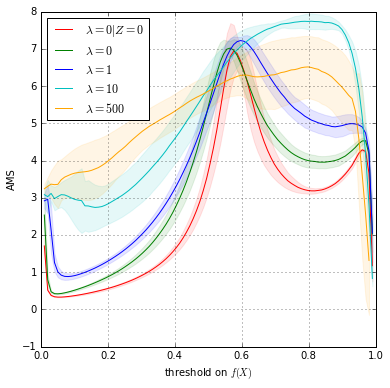

In [11]:
import glob

indices = np.random.permutation(len(X))
indices = indices[:5000000]

for lam, c in zip([0.0], ["r"]):
    ams = []

    for f in glob.glob("D-%.4f-*.h5" % lam):
        print(f)
        D.load_weights(f)
        cuts, a = plot_AMS1(D.predict(X[indices]), y[indices], z[indices, 1], f)
        ams.append(a)
        
    mu = np.mean(ams, axis=0) 
    std = np.std(ams, axis=0)
    plt.plot(cuts, mu, label=r"$\lambda=%d|Z=0$" % lam, c=c)
    plt.fill_between(cuts, mu+std, mu-std, color=c, alpha=0.1)
    
for lam, c in zip([0.0, 1.0, 10, 500.], ["g", "b", "c", "orange", "y", "grey", "k"]):
    ams = []

    for f in glob.glob("y=0/D-%.4f-*.h5" % lam):
        print(f)
        D.load_weights(f)
        cuts, a = plot_AMS1(D.predict(X[indices]), y[indices], z[indices, 1], f)
        ams.append(a)
        
    mu = np.mean(ams, axis=0) 
    std = np.std(ams, axis=0)
    plt.plot(cuts, mu, label=r"$\lambda=%d$" % lam, c=c)
    plt.fill_between(cuts, mu+std, mu-std, color=c, alpha=0.1)
    
plt.legend(loc="best")
plt.ylabel("AMS")
plt.xlabel("threshold on $f(X)$")
plt.grid()
plt.savefig("ams.pdf")
plt.show()